**Brian Blaylock**  
**August 28, 2019**

# I am learning about how to use Zarr data
Zarr looks to be a useful cloud-friendly data format. I wonder if it would be beneficial to have the HRRR data on Pando stored as Zarr. Supposedly this would make subsetting the HRRR dataset easier.

The first thing that is needed is ability to interact with S3 objects with the `s3fs` python module. Then we can play with zarr files with the `zarr` module.

Environment packages are listed in `environment_zarr.yml` located at the head of pyBKB_v3. To create this new environment:

    conda env create -f environment_zarr.yml
   
And to activate it, 

    conda activate test_zarr
   
   
---

In [1]:
import s3fs
import zarr
import numpy as np
import matplotlib.pyplot as plt


np.set_printoptions(threshold=15)  # Just want to limit printing long np.array

# Access public AWS bucket with `s3fs`
With `s3fs` first look at the `noaa-goes16` bucket contents and download a file.


https://s3fs.readthedocs.io/en/latest/api.html


In [2]:
# Use the anonymous credentials to access public data
fs = s3fs.S3FileSystem(anon=True)

In [3]:
# List contents of GOES-16 bucket
np.array(fs.ls('s3://noaa-goes16/'))

array(['noaa-goes16/ABI-L1b-RadC', 'noaa-goes16/ABI-L1b-RadF',
       'noaa-goes16/ABI-L1b-RadM', 'noaa-goes16/ABI-L2-CMIPC',
       'noaa-goes16/ABI-L2-CMIPF', 'noaa-goes16/ABI-L2-CMIPM',
       'noaa-goes16/ABI-L2-FDCC', 'noaa-goes16/ABI-L2-FDCF',
       'noaa-goes16/ABI-L2-MCMIPC', 'noaa-goes16/ABI-L2-MCMIPF',
       'noaa-goes16/ABI-L2-MCMIPM', 'noaa-goes16/GLM-L2-LCFA',
       'noaa-goes16/index.html'], dtype='<U25')

In [4]:
# List specific files of GOES-17 CONUS data (multiband format) on a certain hour
# Doesn't look like the `s3://` is required
files = np.array(fs.ls('noaa-goes17/ABI-L2-MCMIPC/2019/240/00/'))
print(files)

['noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s20192400001197_e20192400003581_c20192400004108.nc'
 'noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s20192400006197_e20192400008581_c20192400009101.nc'
 'noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s20192400011197_e20192400013575_c20192400014104.nc'
 'noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s20192400016197_e20192400018575_c20192400019095.nc'
 'noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s20192400021197_e20192400023575_c20192400024095.nc'
 'noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s20192400026197_e20192400028575_c20192400029090.nc'
 'noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s20192400031197_e20192400033575_c20192400034108.nc'
 'noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s20192400036197_e20192400038581_c20192400039094.nc'
 'noaa-goes17/ABI-L2-MCMIPC/2019/240/00/OR_ABI-L2-MCMIPC-M6_G17_s2019240

In [5]:
# Download the first file, rename it the same name (without the directory structure)
fs.get(files[0], files[0].split('/')[-1])

# Access files on Pando
To access public files on Pando with `s3fs`, you need to specify the `endpoint_url`

    client_kwargs={'endpoint_url':"https://pando-rgw01.chpc.utah.edu/"}

S3 buckets on Pando must be public to access it anonomously. For example,

    ./s3cmd setacl s3://BB_TEST --acl-public
    ./s3cmd setacl -r s3://BB_TEST/GOES16_Dorian.zarr --acl-public
    
> Note: the installation for s3cmd is located here: `/uufs/chpc.utah.edu/common/home/horel-group7/Pando_Scripts/s3cmd-2.0.1/s3cmd`

In [6]:
# Access Pando
fs = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url':"https://pando-rgw01.chpc.utah.edu/"})

In [7]:
files = np.array(fs.ls('hrrr/sfc/20190101/'))
print(files)

['hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2'
 'hrrr/sfc/20190101/hrrr.t00z.wrfsfcf00.grib2.idx'
 'hrrr/sfc/20190101/hrrr.t00z.wrfsfcf01.grib2' ...
 'hrrr/sfc/20190101/hrrr.t23z.wrfsfcf17.grib2.idx'
 'hrrr/sfc/20190101/hrrr.t23z.wrfsfcf18.grib2'
 'hrrr/sfc/20190101/hrrr.t23z.wrfsfcf18.grib2.idx']


In [8]:
# Download the first file, rename it the same name (without the directory structure)
fs.get(files[0], files[0].split('/')[-1])

# From Zarr Demo
https://zarr.readthedocs.io/en/stable/tutorial.html#distributed-cloud-storage


In [9]:
# NOTE: Do not need to specify the endpoint_url becuase this is from AWS
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name='eu-west-2'))
store = s3fs.S3Map(root='zarr-demo/store', s3=s3, check=False)
root = zarr.group(store=store)

In [10]:
root

<zarr.hierarchy.Group '/'>

In [11]:
z = root['foo/bar/baz']

In [12]:
z

<zarr.core.Array '/foo/bar/baz' (21,) |S1>

In [13]:
z.info

Name,/foo/bar/baz
Type,zarr.core.Array
Data type,|S1
Shape,"(21,)"
Chunk shape,"(7,)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,fsspec.mapping.FSMap
No. bytes,21
Chunks initialized,3/3


In [14]:
z[:]

array([b'H', b'e', b'l', ..., b'u', b'd', b'!'], dtype='|S1')

In [15]:
z[:].tostring()

b'Hello from the cloud!'

In [16]:
z[0:5].tostring()

b'Hello'

### Zarr storage cache
Speeds up retrieval if you have already _mapped the store???_

In [17]:
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name='eu-west-2'))
store = s3fs.S3Map(root='zarr-demo/store', s3=s3, check=False)
cache = zarr.LRUStoreCache(store, max_size=2**28)
root = zarr.group(store=cache)
z = root['foo/bar/baz']
from timeit import timeit
# first data access is relatively slow, retrieved from store
timeit('print(z[:].tostring())', number=1, globals=globals())  

b'Hello from the cloud!'


0.3868441020604223

In [18]:
# second data access is faster, uses cache
timeit('print(z[:].tostring())', number=1, globals=globals())  

b'Hello from the cloud!'


0.0006542860064655542

# Creating a zarr file/directory with xarray
`xarray` has a method to convert a dataset to zarr called `dataset.to_zar`. Here, I convert a GOES16 `.nc` file to zarr.

If you just use the default options, xarray converts the arrays to integers becuase it doesn't know what to do with the nan values in the GOES band arrays. This is a problem becuase it changes the units of the array. Instead, yo uneed to specify the encoding data type to force xarray to convert the data to zarr as a float value, and not change it to an integer.

In [35]:
# Hurricane Dorian
# A NetCDF file downloaded from AWS
G16 = 'OR_ABI-L2-MCMIPC-M6_G16_s20192411711162_e20192411713546_c20192411714092.nc'

In [36]:
import xarray
x = xarray.open_dataset(G16)

In [37]:
x['CMI_C01'].data

array([[       nan,        nan,        nan, ..., 0.27333307, 0.28380924,
        0.24190453],
       [       nan,        nan,        nan, ..., 0.30158702, 0.27650768,
        0.2819045 ],
       [       nan,        nan,        nan, ..., 0.23365057, 0.2612696 ,
        0.27015847],
       ...,
       [0.17968237, 0.19015855, 0.19809505, ..., 0.10761894, 0.10730148,
        0.10730148],
       [0.20031726, 0.20920615, 0.20031726, ..., 0.10730148, 0.10761894,
        0.10730148],
       [0.21396805, 0.21174583, 0.2073014 , ..., 0.1079364 , 0.10730148,
        0.10698403]], dtype=float32)

In [32]:
encode_dict = {}
for i in range(1,17):
    encode_dict['CMI_C%02d' % i] = {'dtype':float}
    encode_dict['DQF_C%02d' % i] = {'dtype':float}
#encode_dict

In [33]:
x.to_zarr('GOES16_Dorian.zarr', encoding=encode_dict)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/test_zarr/lib/python3.7/site-packages/xarray/core/dataset.py:1433: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  consolidated=consolidated, append_dim=append_dim)


I put the `GOES16_Dorian.zarr` on Pando, and changed the acl permission to public.


# OK, so I converted a GOES-East file to zarr and put it on Pando.
I used the xarray convert the file to zarr with the method `Dataset.to_zarr()`

Look at the `GOES16_Dorian.zarr` directory here: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/generic_pando_download.cgi?BUCKET=BB_TEST

The acl of the bucket and all it's contents was set to public.    

It looks like it chuncked every variable into a group

What can I do with that zarr file on Pando?

In [38]:
fs = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url':"https://pando-rgw01.chpc.utah.edu/"})
contents = np.array(fs.ls('BB_TEST/GOES16_Dorian.zarr'))
print(contents)

['BB_TEST/GOES16_Dorian.zarr/.zattrs' 'BB_TEST/GOES16_Dorian.zarr/.zgroup'
 'BB_TEST/GOES16_Dorian.zarr/CMI_C01' ... 'BB_TEST/GOES16_Dorian.zarr/y'
 'BB_TEST/GOES16_Dorian.zarr/y_image'
 'BB_TEST/GOES16_Dorian.zarr/y_image_bounds']


In [39]:
store = s3fs.S3Map(root='BB_TEST/GOES16_Dorian.zarr/', s3=fs, check=False)
root = zarr.group(store=store)

In [26]:
# What is inside this "root"?
# This is a zarr Group with lots of arrays and chunks inside
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,fsspec.mapping.FSMap
No. members,161
No. arrays,161
No. groups,0
Arrays,"CMI_C01, CMI_C02, CMI_C03, CMI_C04, CMI_C05, CMI_C06, CMI_C07, CMI_C08, CMI_C09, CMI_C10, CMI_C11, CMI_C12, CMI_C13, CMI_C14, CMI_C15, CMI_C16, DQF_C01, DQF_C02, DQF_C03, DQF_C04, DQF_C05, DQF_C06, DQF_C07, DQF_C08, DQF_C09, DQF_C10, DQF_C11, DQF_C12, DQF_C13, DQF_C14, DQF_C15, DQF_C16, algorithm_product_version_container, band_id_C01, band_id_C02, band_id_C03, band_id_C04, band_id_C05, band_id_C06, band_id_C07, band_id_C08, band_id_C09, band_id_C10, band_id_C11, band_id_C12, band_id_C13, band_id_C14, band_id_C15, band_id_C16, band_wavelength_C01, band_wavelength_C02, band_wavelength_C03, band_wavelength_C04, band_wavelength_C05, band_wavelength_C06, band_wavelength_C07, band_wavelength_C08, band_wavelength_C09, band_wavelength_C10, band_wavelength_C11, band_wavelength_C12, band_wavelength_C13, band_wavelength_C14, band_wavelength_C15, band_wavelength_C16, dynamic_algorithm_input_data_container, geospatial_lat_lon_extent, goes_imager_projection, max_brightness_temperature_C07, max_brightness_temperature_C08, max_brightness_temperature_C09, max_brightness_temperature_C10, max_brightness_temperature_C11, max_brightness_temperature_C12, max_brightness_temperature_C13, max_brightness_temperature_C14, max_brightness_temperature_C15, max_brightness_temperature_C16, max_reflectance_factor_C01, max_reflectance_factor_C02, max_reflectance_factor_C03, max_reflectance_factor_C04, max_reflectance_factor_C05, max_reflectance_factor_C06, mean_brightness_temperature_C07, mean_brightness_temperature_C08, mean_brightness_temperature_C09, mean_brightness_temperature_C10, mean_brightness_temperature_C11, mean_brightness_temperature_C12, mean_brightness_temperature_C13, mean_brightness_temperature_C14, mean_brightness_temperature_C15, mean_brightness_temperature_C16, mean_reflectance_factor_C01, mean_reflectance_factor_C02, mean_reflectance_factor_C03, mean_reflectance_factor_C04, mean_reflectance_factor_C05, mean_reflectance_factor_C06, min_brightness_temperature_C07, min_brightness_temperature_C08, min_brightness_temperature_C09, min_brightness_temperature_C10, min_brightness_temperature_C11, min_brightness_temperature_C12, min_brightness_temperature_C13, min_brightness_temperature_C14, min_brightness_temperature_C15, min_brightness_temperature_C16, min_reflectance_factor_C01, min_reflectance_factor_C02, min_reflectance_factor_C03, min_reflectance_factor_C04, min_reflectance_factor_C05, min_reflectance_factor_C06, nominal_satellite_height, nominal_satellite_subpoint_lat, nominal_satellite_subpoint_lon, outlier_pixel_count_C01, outlier_pixel_count_C02, outlier_pixel_count_C03, outlier_pixel_count_C04, outlier_pixel_count_C05, outlier_pixel_count_C06, outlier_pixel_count_C07, outlier_pixel_count_C08, outlier_pixel_count_C09, outlier_pixel_count_C10, outlier_pixel_count_C11, outlier_pixel_count_C12, outlier_pixel_count_C13, outlier_pixel_count_C14, outlier_pixel_count_C15, outlier_pixel_count_C16, percent_uncorrectable_GRB_errors, percent_uncorrectable_L0_errors, std_dev_brightness_temperature_C07, std_dev_brightness_temperature_C08, std_dev_brightness_temperature_C09, std_dev_brightness_temperature_C10, std_dev_brightness_temperature_C11, std_dev_brightness_temperature_C12, std_dev_brightness_temperature_C13, std_dev_brightness_temperature_C14, std_dev_brightness_temperature_C15, std_dev_brightness_temperature_C16, std_dev_reflectance_factor_C01, std_dev_reflectance_factor_C02, std_dev_reflectance_factor_C03, std_dev_reflectance_factor_C04, std_dev_reflectance_factor_C05, std_dev_reflectance_factor_C06, t, time_bounds, x, x_image, x_image_bounds, y, y_image, y_image_bounds"


In [28]:
# Lists the attribute keys
root.attrs.keys()

dict_keys(['Conventions', 'Metadata_Conventions', 'cdm_data_type', 'coordinates', 'dataset_name', 'date_created', 'id', 'institution', 'instrument_ID', 'instrument_type', 'iso_series_metadata_id', 'keywords', 'keywords_vocabulary', 'license', 'naming_authority', 'orbital_slot', 'platform_ID', 'processing_level', 'production_data_source', 'production_environment', 'production_site', 'project', 'scene_id', 'spatial_resolution', 'standard_name_vocabulary', 'summary', 'time_coverage_end', 'time_coverage_start', 'timeline_id', 'title'])

In [29]:
# Lists the attribute keys and values
root.attrs.asdict()

{'Conventions': 'CF-1.7',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'cdm_data_type': 'Image',
 'coordinates': 'band_id_C06 band_id_C09 band_id_C01 band_id_C07 band_id_C12 band_wavelength_C10 band_id_C13 band_wavelength_C11 band_id_C05 band_id_C03 band_wavelength_C05 band_wavelength_C02 band_id_C08 band_id_C02 band_wavelength_C06 band_wavelength_C16 band_id_C15 band_id_C14 band_wavelength_C07 band_wavelength_C15 band_wavelength_C01 band_wavelength_C12 band_wavelength_C08 band_wavelength_C03 band_wavelength_C09 band_wavelength_C14 band_id_C10 band_wavelength_C13 band_id_C11 band_wavelength_C04 band_id_C04 band_id_C16',
 'dataset_name': 'OR_ABI-L2-MCMIPC-M6_G16_s20192411711162_e20192411713546_c20192411714092.nc',
 'date_created': '2019-08-29T17:14:09.2Z',
 'id': 'f3df8b7d-ac7b-4ebd-9de1-0eec5f71ad6a',
 'institution': 'DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Ser

In [30]:
# Look at a specific array inside the root group
root['CMI_C01'].info

Name,/CMI_C01
Type,zarr.core.Array
Data type,float64
Shape,"(1500, 2500)"
Chunk shape,"(188, 625)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,fsspec.mapping.FSMap
No. bytes,30000000 (28.6M)
Chunks initialized,32/32


In [31]:
# List the attribute keys and values
root['CMI_C01'].attrs.asdict()

{'_ARRAY_DIMENSIONS': ['y', 'x'],
 'ancillary_variables': 'DQF_C01',
 'cell_methods': 't: point area: sum (interval: 0.000028 rad)',
 'coordinates': 'x_image t y_image',
 'downsampling_method': 'average',
 'grid_mapping': 'goes_imager_projection',
 'long_name': 'ABI Cloud and Moisture Imagery reflectance factor',
 'resolution': 'y: 0.000056 rad x: 0.000056 rad',
 'sensor_band_bit_depth': 10,
 'standard_name': 'toa_lambertian_equivalent_albedo_multiplied_by_cosine_solar_zenith_angle',
 'units': '1',
 'valid_range': [0, 4095]}

In [32]:
# Print the value of the array
# Why is the data type an int16 and not a float?
root['CMI_C01']

<zarr.core.Array '/CMI_C01' (1500, 2500) float64>

In [33]:
root['CMI_C01'][:]

array([[       nan,        nan,        nan, ..., 0.27333307, 0.28380924,
        0.24190453],
       [       nan,        nan,        nan, ..., 0.30158702, 0.27650768,
        0.28190449],
       [       nan,        nan,        nan, ..., 0.23365057, 0.2612696 ,
        0.27015847],
       ...,
       [0.17968237, 0.19015855, 0.19809505, ..., 0.10761894, 0.10730148,
        0.10730148],
       [0.20031726, 0.20920615, 0.20031726, ..., 0.10730148, 0.10761894,
        0.10730148],
       [0.21396805, 0.21174583, 0.20730139, ..., 0.1079364 , 0.10730148,
        0.10698403]])

### Plot all 16 bands

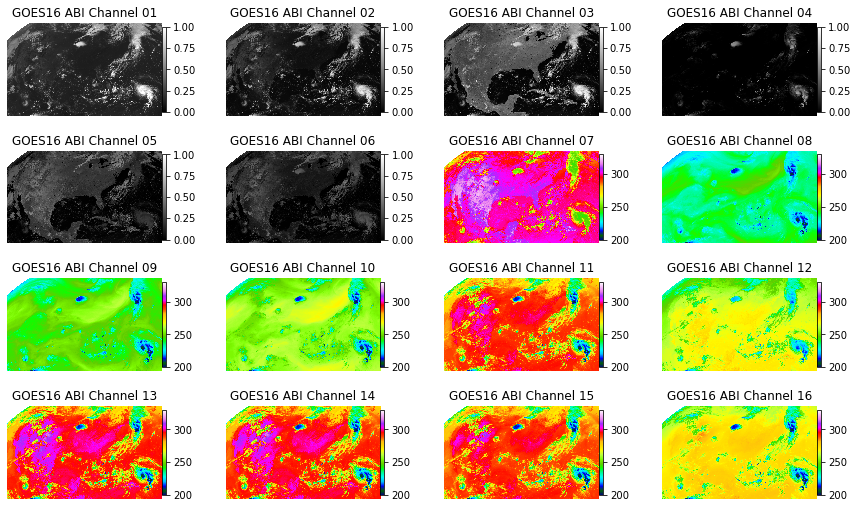

In [40]:
fig, axes = plt.subplots(4,4, figsize=[15,9])
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i+1 >= 7:
        cmap = 'gist_ncar'
        vmax=330
        vmin=200
    else:
        cmap = 'gray'
        vmax=1
        vmin=0
    plt.sca(ax)
    plt.imshow(root['CMI_C%02d' % (i+1)][:], cmap=cmap, vmax=vmax, vmin=vmin)
    plt.colorbar(pad=0, shrink=.8)
    ax.set_title('GOES16 ABI Channel %02d' % (i+1))
    ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


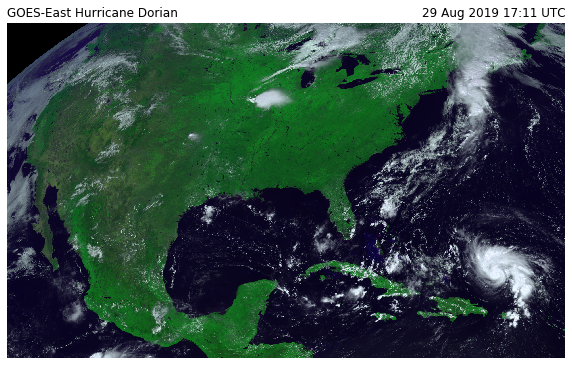

In [41]:
plt.figure(figsize=[10,8])
RGB = np.dstack([root['CMI_C02'][:], root['CMI_C03'][:], root['CMI_C01'][:]])
plt.imshow(RGB)
plt.axis('off')
plt.title('GOES-East Hurricane Dorian', loc='left');

from datetime import datetime
t = root.attrs['time_coverage_start']
T = datetime.strptime(t, '%Y-%m-%dT%H:%M:%S.%fZ')
plt.title(T.strftime('%d %b %Y %H:%M UTC'), loc='right');

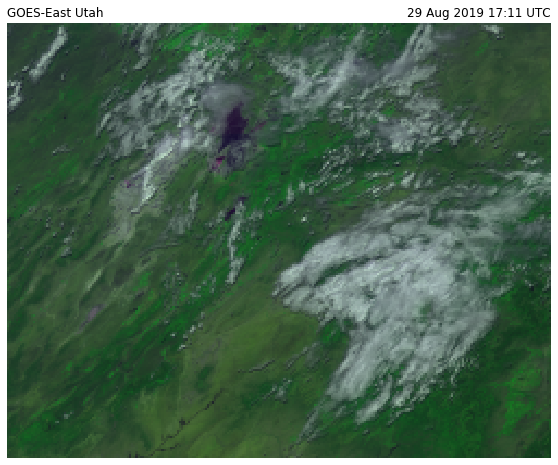

In [42]:
sub1 = slice(300,500)
sub2 = slice(350,600)

plt.figure(figsize=[10,8])
RGB = np.dstack([root['CMI_C02'][sub1,sub2], root['CMI_C03'][sub1,sub2], root['CMI_C01'][sub1,sub2]])
plt.imshow(RGB)
plt.axis('off')
plt.title('GOES-East Utah', loc='left');

from datetime import datetime
t = root.attrs['time_coverage_start']
T = datetime.strptime(t, '%Y-%m-%dT%H:%M:%S.%fZ')
plt.title(T.strftime('%d %b %Y %H:%M UTC'), loc='right');

Ok, so I can plot a GOES16 image in zarr format on Pando. I'm not sure why the chuck size is what it is. Did xarray decide the chunks for me?